In [115]:
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from tqdm.auto import tqdm

In [120]:
def to_binary(s: str):
    b = bin(int.from_bytes(s.encode(), 'big'))
    b_list = [int(bi) for bi in b[2:]]
    return np.array(b_list)

def to_str(b_array):
    b_array = np.copy(b_array)
    b_array[b_array == -1] = 0
    b = "".join([str(int(n)) for n in b_array])
    b = "0b" + b
    n = int(b, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()

b = to_binary("Clinton")
s = to_str(b)
print(b)
print(s)

[1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0]
Clinton


In [121]:
X = ["Clinton", "Hillary", "Kenstar"]
Y = ["President", "FirstLady", "Gentleman"]
X_b = np.array([to_binary(s) for s in X]) * 2 - 1
Y_b = np.array([to_binary(s) for s in Y]) * 2 - 1
X_b

array([[ 1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1,
         1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1,
         1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1, -1,
         1,  1, -1,  1,  1,  1, -1],
       [ 1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1,
         1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1,
         1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,
         1,  1,  1,  1, -1, -1,  1],
       [ 1, -1, -1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,
         1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,
         1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,
         1,  1,  1, -1, -1,  1, -1]])

# 1)

In [165]:
class BamTrainer:
    def __init__(self, input_size: int, output_size: int, modified=False, threshold=0):
        self.weights = np.zeros((input_size, output_size))
        self.modified = modified
        self.threshold = threshold
        self.input_size = input_size
        self.output_size = output_size

    def train(self, inputs, outputs):
        for i, o in zip(inputs, outputs):
            i = i.reshape(1, -1)
            o = o.reshape(1, -1)
            self.weights += i.T @ o
        # Modification
        if self.modified:
            np.fill_diagonal(self.weights, 0)
    
    def predict(self, i, pred_y=True, max_iter=20, log_steps=1000, save_images=True, verbose=False):
        def update_x(x, y):
            for y_idx in np.arange(y.shape[-1]):
                y_in = np.dot(x[0], self.weights[:, y_idx])
                if y_in > self.threshold:
                    y[0][y_idx] = 1
                elif y_in < self.threshold:
                    y[0][y_idx] = -1
                    
        def update_y(x, y):
            for x_idx in np.arange(x.shape[-1]):
                x_in = np.dot(y[0], self.weights[x_idx, :])
                if x_in > self.threshold:
                    x[0][x_idx] = 1
                elif x_in < self.threshold:
                    x[0][x_idx] = -1
                    
        visited_patterns = []
        i = i.reshape(1, -1)
        if pred_y:
            x = np.copy(i)  # Present input pattern x to the X-layer
            y = np.zeros((1, self.output_size))
        else:
            y = np.copy(i)  # Present input pattern x to the X-layer
            x = np.zeros((1, self.input_size))
        tqdm_v = tqdm if verbose else lambda x: x
        for iteration in tqdm_v(range(max_iter)):
#             print(f"### Iteration {iteration} ###")
            if pred_y:
                # Update activations of units in Y-layer
                update_y(x, y)
                # Update activations of units in X-layer
                update_x(x, y)
                output = y
            else:
                update_x(x, y)
                update_y(x, y)
                output = x
            # Test for convergence:
            if str(output.flatten()) in visited_patterns:
                break
            else:
                visited_patterns.append(str(output.flatten()))
        return output.flatten()
    
    def draw_weights(self):
        mat = self.weights
        plt.figure(figsize=(14, 8))
        plt.matshow(mat, cmap=plt.cm.hot, fignum=False)
        for (x, y), value in np.ndenumerate(mat.T):
            plt.text(x, y, f"{value:.0f}", va="center", ha="center", color="gray")

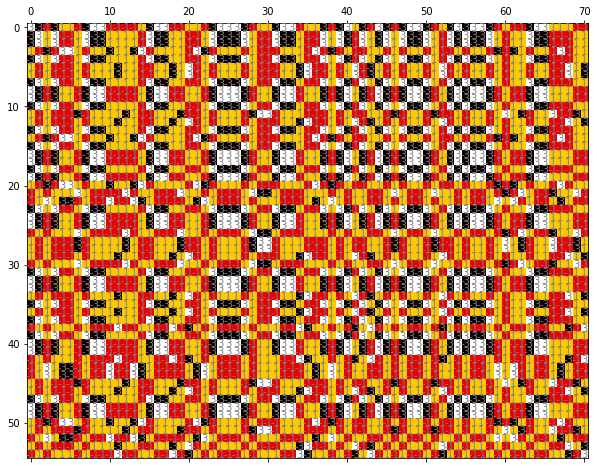

In [139]:
bam = BamTrainer(X_b.shape[1], Y_b.shape[1], modified=False)
bam.train(X_b, Y_b)
bam.draw_weights()

# 2)

In [140]:
def accuracy(a1, a2):
    return np.sum(a1 == a2) / len(a1) * 100

preds = np.array([bam.predict(x, pred_y=True) for x in X_b])
for i in range(3):
    print("Input:", to_str(X_b[i]), "| Pred:", to_str(preds[i]), "| Accuracy:", accuracy(Y_b[i], preds[i]))
    
preds = np.array([bam.predict(y, pred_y=False) for y in Y_b])
for i in range(3):
    print("Input:", to_str(Y_b[i]), "| Pred:", to_str(preds[i]), "| Accuracy:", accuracy(X_b[i], preds[i]))

Input: Clinton | Pred: President | Accuracy: 100.0
Input: Hillary | Pred: FirstLady | Accuracy: 100.0
Input: Kenstar | Pred: Gentleman | Accuracy: 100.0
Input: President | Pred: Clinton | Accuracy: 100.0
Input: FirstLady | Pred: Hillary | Accuracy: 100.0
Input: Gentleman | Pred: Kenstar | Accuracy: 100.0


# 3)

In [145]:
def add_noise(array, noise_ratio=0.2):
    array = np.copy(array)
    for i in range(len(array)):
        for j in range(len(array[i])):
            if random.random() < noise_ratio:
                array[i][j] *= -1
    return array

def is_equal(true, preds):
    eq = []
    for i in range(len(preds)):
        eq.append(np.array_equal(preds[i], true[i]))
    return eq

def evaluate_noise_x_to_y(noise_ratio, bam):
    class_acc = [[], [], []]
    for i in range(100):
        noisy_inputs = add_noise(X_b, noise_ratio=noise_ratio)
        preds = [bam.predict(x, pred_y=True) for x in noisy_inputs]
        for i in range(len(preds)):
            class_acc[i].append(accuracy(Y_b[i], preds[i]))
    print(f"Noise {noise_ratio * 100}% - Average Accuracy (over 100 runs): {np.array(class_acc).mean(axis=-1)}% -> {np.mean(class_acc):.2f}%")

def evaluate_noise_y_to_x(noise_ratio, bam):
    class_acc = [[], [], []]
    for i in range(100):
        noisy_inputs = add_noise(Y_b, noise_ratio=noise_ratio)
        preds = [bam.predict(y, pred_y=False) for y in noisy_inputs]
        for i in range(len(preds)):
            class_acc[i].append(accuracy(X_b[i], preds[i]))
    print(f"Noise {noise_ratio * 100}% - Average Accuracy (over 100 runs): {np.array(class_acc).mean(axis=-1)}% -> {np.mean(class_acc):.2f}%")

    
evaluate_noise_x_to_y(0.1, bam)
evaluate_noise_x_to_y(0.2, bam)
evaluate_noise_y_to_x(0.1, bam)
evaluate_noise_y_to_x(0.2, bam)

Noise 10.0% - Average Accuracy (over 100 runs): [98.90140845 99.85915493 99.15492958]% -> 99.31%
Noise 20.0% - Average Accuracy (over 100 runs): [96.33802817 99.15492958 96.78873239]% -> 97.43%
Noise 10.0% - Average Accuracy (over 100 runs): [ 99.70909091 100.          99.70909091]% -> 99.81%
Noise 20.0% - Average Accuracy (over 100 runs): [98.83636364 97.8        97.81818182]% -> 98.15%


In [148]:
import pandas as pd
pd.DataFrame([[98.90140845, 99.85915493, 99.15492958], 
              [96.33802817, 99.15492958, 96.78873239], 
              [ 99.70909091, 100., 99.70909091],
              [98.83636364, 97.8, 97.81818182]
             ],
             columns=["Clinton/President", "Hillary/FirstLady", "Kenstar/Gentleman"],
             index=["x_to_y 10% Noise", "x_to_y 20% Noise", "y_to_x 10% Noise", "y_to_x 20% Noise"]
            )

,Clinton/President,Hillary/FirstLady,Kenstar/Gentleman
x_to_y 10% Noise,98.901408,99.859155,99.154930
x_to_y 20% Noise,96.338028,99.154930,96.788732
y_to_x 10% Noise,99.709091,100.000000,99.709091
y_to_x 20% Noise,98.836364,97.800000,97.818182


# 4)

In [155]:
X = ["Clinton", "Hillary", "Kenstar", "Lewisky"]
Y = ["President", "FirstLady", "Gentleman", "SweetGirl"]
X_b = np.array([to_binary(s) for s in X]) * 2 - 1
Y_b = np.array([to_binary(s) for s in Y]) * 2 - 1
# X_b

In [166]:
def accuracy(a1, a2):
    return np.round(np.sum(a1 == a2) / len(a1) * 100, 2)

bam = BamTrainer(X_b.shape[1], Y_b.shape[1], modified=False)
bam.train(X_b, Y_b)

preds = np.array([bam.predict(x, pred_y=True) for x in X_b])
for i in range(4):
    print("Input:", to_str(X_b[i]), "| Pred:", to_str(preds[i]), "| Accuracy:", accuracy(Y_b[i], preds[i]))
    
preds = np.array([bam.predict(y, pred_y=False) for y in Y_b])
for i in range(4):
    print("Input:", to_str(Y_b[i]), "| Pred:", to_str(preds[i]), "| Accuracy:", accuracy(X_b[i], preds[i]))

Input: Clinton | Pred: Rsesldef| | Accuracy: 91.55
Input: Hillary | Pred: FafstDad| | Accuracy: 91.55
Input: Kenstar | Pred: Gefulem`l | Accuracy: 94.37
Input: Lewisky | Pred: SweutEibl | Accuracy: 95.77
Input: President | Pred: Kmmntkz | Accuracy: 89.09
Input: FirstLady | Pred: Hmllqcy | Accuracy: 92.73
Input: Gentleman | Pred: Kenktcz | Accuracy: 92.73
Input: SweetGirl | Pred: Heoiqky | Accuracy: 92.73
